In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

import sys
sys.path.insert(0, '/Users/bmmorris/git/gravdark/')

from gravdark import LightCurve, tres2_params
from gravdark.lightcurve import concatenate_light_curves

t2_path = glob('/Users/bmmorris/data/gravdark/tres2/*slc.fits')
t2_lc_whole = LightCurve.from_raw_fits(t2_path, name='TrES-2 b')

t2_masked = LightCurve(**t2_lc_whole.mask_out_of_transit(tres2_params(), oot_duration_fraction=0.5))
t2_transits = t2_masked.get_transit_light_curves(tres2_params())
for transit in t2_transits:
    transit.remove_linear_baseline(tres2_params())
t2 = concatenate_light_curves(t2_transits)

In [3]:
params = tres2_params()
params.b = 0.8540

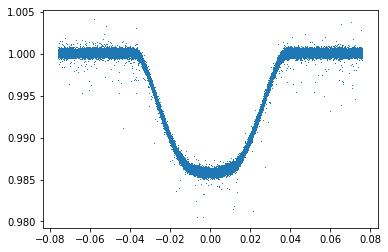

In [80]:
times, all_fluxes = t2.phases(tres2_params()) * tres2_params().per, t2.fluxes

all_fluxes = all_fluxes[np.argsort(times)]
times = times[np.argsort(times)]

yerr = np.std(all_fluxes[:1000])
plt.plot(times, all_fluxes, ',', rasterized=True)

In [91]:
from copy import deepcopy
import batman

def kipping_to_quadratic(p):
    q1, q2 = p
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    return u1, u2

def transit_model(theta, x):
    r0, r1, q1, q2, f0 = theta
    trial_params = deepcopy(params)
    trial_params.rp0 = r0
    trial_params.rp1 = r1
    trial_params.u = kipping_to_quadratic([q1, q2])
    trial_params.t0 = 0
    
    m = batman.TransitModel(trial_params, x, exp_time=1/60/24, supersample_factor=2)
    fluxes = f0 * m.light_curve(trial_params)
    
    return fluxes
    
def lnlike(theta, x, y, yerr):
    r0, r1, q1, q2, f0 = theta
    model = transit_model(theta, x) 
    return -0.5*np.sum((model - y)**2 / yerr**2)

def lnprior(theta):
    r0, r1, q1, q2, f0 = theta
    if 0 < r0 < 1 and 0.0 < r1 < 1 and 0 < q1 < 1 and 0 < q2 < 1 and 0 < f0 < 1.5:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


ndim, nwalkers = 5, 10
#pos = [[params.rp, params.rp, 0] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
pos = []

q1 = (params.u[0] + params.u[1])**2
q2 = 0.5 * params.u[0] / (params.u[0] + params.u[1])

while len(pos) < nwalkers: 
    trial_pos = [params.rp, params.rp, q1, q2, 1] + 1e-2*np.random.randn(ndim)
    if np.isfinite(lnprior(trial_pos)):
        pos.append(trial_pos)

import emcee
fluxes = all_fluxes
# yerr = np.ones_like(fluxes) * fluxes.std()/10
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times, fluxes, yerr),
                                threads=4)

In [92]:
params.rp

0.12539

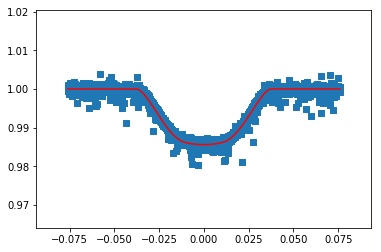

In [94]:
init_f = transit_model([params.rp*1, params.rp*1., q1, q2, 1], times)

#plt.errorbar(times, fluxes, yerr, fmt='.', color='k', ecolor='gray')
plt.scatter(times, fluxes, marker=',')
plt.plot(times, init_f, 'r', zorder=10)

In [96]:
sampler.run_mcmc(pos, 10000); 

In [97]:
# np.savetxt('tres2_samples.txt', sampler.flatchain)

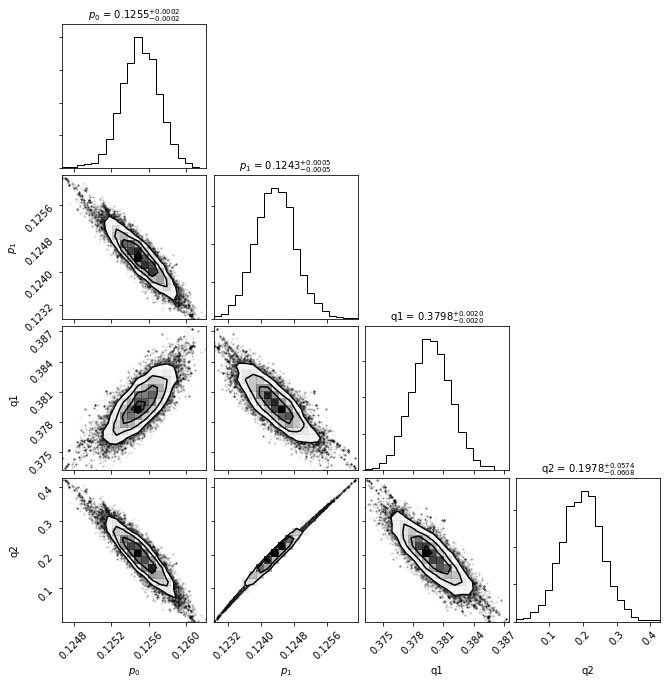

In [98]:
from corner import corner

nburnin = 5000
#fig, ax = plt.subplots(2, 2, figsize=(4, 4))
# corner(sampler.chain[:, 3000:, :2].reshape((-1, ndim-3)), truths=[params.rp, params.rp], 
#        labels=['$p_0$', '$p_1$'], fig=fig, show_titles=True, title_fmt='.6f', title_kwargs=dict(fontsize=10));

corner(sampler.chain[:, 5000:, :-1].reshape((-1, ndim-1)), #truths=[params.rp, params.rp], 
       labels=['$p_0$', '$p_1$', 'q1', 'q2'], show_titles=True, #fig=fig, 
       title_fmt='.4f', title_kwargs=dict(fontsize=10));


# for i, axis in enumerate(fig.axes):
#     axis.set_xlim([0.1246, 0.1260])
#     if i == 3: 
#         axis.set_xlim([0.12475, 0.12550])
# plt.savefig('corner_quad_tres2.pdf', bbox_inches='tight')

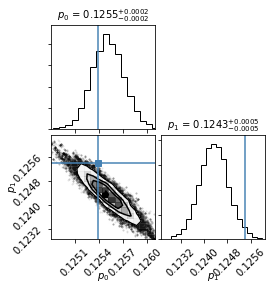

In [109]:
fig, ax = plt.subplots(2, 2, figsize=(4, 4))
corner(sampler.chain[:, 3000:, :2].reshape((-1, ndim-3)), truths=[params.rp, params.rp], 
       labels=['$p_0$', '$p_1$'], fig=fig, show_titles=True, title_fmt='.4f', title_kwargs=dict(fontsize=10));

for i, axis in enumerate(fig.axes):
    axis.set_xlim([0.1248, 0.1261])
    if i == 3: 
        axis.set_xlim([0.1225, 0.1261])
plt.savefig('corner_quad_tres2.pdf', bbox_inches='tight')

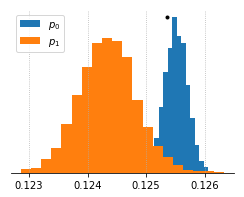

In [116]:
plt.figure(figsize=(4, 3))

fmax = 0
for p, label in zip(sampler.chain[:, 5000:, :2].reshape((-1, ndim-3)).T, 
                    ['$p_0$', '$p_1$']):
    n, _, _ = plt.hist(p, bins=20, histtype='stepfilled', label=label)
    fmax = max([n.max(), fmax])
ax = plt.gca()
ax.grid(ls=':')
ax.legend()
ax.set(yticks=[])

# Barclay 2012
rprs_lit = 0.125358
rprs_err_lit = 0.00002

ax.errorbar(rprs_lit, fmax, xerr=rprs_err_lit, fmt='.', color='k')

for s in ['right', 'top', 'left']:
    ax.spines[s].set_visible(False)

plt.savefig('tres2_agreement.pdf', bbox_inches='tight')

In [120]:
from scipy.stats import ttest_ind

ttest_ind(sampler.chain[:, 5000:, :2].reshape((-1, ndim-3))[:, 0],
          sampler.chain[:, 5000:, :2].reshape((-1, ndim-3))[:, 1],
          equal_var=False)

Ttest_indResult(statistic=486.5181547262307, pvalue=0.0)

In [11]:
# plt.scatter(sampler.chain[:, 3000:, 0], sampler.chain[:, 3000:, 1], marker=',', 
#             s=1, alpha=0.5, rasterized=True)
# plt.axvline(params.rp, color='k')
# plt.axhline(params.rp, color='k')

# ax = plt.gca()

# for s in ['right', 'top']:
#     ax.spines[s].set_visible(False)
# # ax.set(xlim=[params.rp-0.1, params.rp+0.1], ylim=[params.rp-0.1, params.rp+0.1])
# ax.set_aspect(1)
# ax.grid(ls=':')
# ax.set(xlabel='$p_0$ (duration)', ylabel='$p_1$ (depth)')
# plt.savefig('depth_posterior_hat7.pdf', dpi=250, bbox_inches='tight')

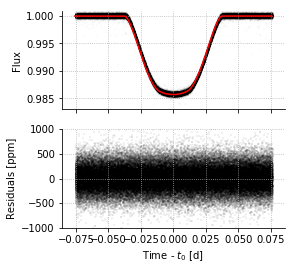

In [108]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
ax[0].scatter(times, fluxes, marker=',', s=1, rasterized=True, alpha=0.01, 
              color='k')

i = np.argmax(sampler.flatlnprobability, axis=0)
ax[0].plot(times, transit_model(sampler.flatchain[i, :], times), color='r')

ax[1].scatter(times, 1e6*(fluxes - transit_model(sampler.flatchain[i, :], times)), 
              marker=',', s=1, rasterized=True, alpha=0.05, 
              color='k')

ax[0].set_ylim([0.983, 1.001])
ax[1].set_ylim([-1000, 1000])

ax[0].set_ylabel('Flux')
ax[1].set(xlabel='Time - $t_0$ [d]', ylabel='Residuals [ppm]')

for axis in ax:
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    axis.grid(ls=':')

fig.savefig('tres2_residuals.pdf', bbox_inches='tight', dpi=250)

(array([   134.,    427.,   1893.,   6196.,  14831.,  19751.,  16142.,
          7722.,   2285.,    619.]),
 array([ 0.98700293,  0.99102412,  0.99504531,  0.99906649,  1.00308768,
         1.00710887,  1.01113006,  1.01515125,  1.01917243,  1.02319362,
         1.02721481]),
 <a list of 10 Patch objects>)

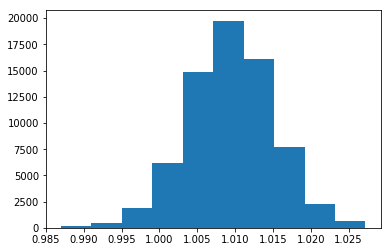

In [110]:
p0 = sampler.chain[:, 3000:, 0].ravel()
p1 = sampler.chain[:, 3000:, 1].ravel()

plt.hist(p0/p1)